# <b>3 - Machine Learning Application to Process Mined Simulated Random Process for Anomaly Detection</b>

Purpose:   
Experiment with Process Mining to determine if feature extraction can contribute to a ML model for anomaly detection and visual representation of procecss anomalies. 

   
-----

<b>Initial Imports</b>   
Imports for specific techniques handled later

In [1]:
import random
from datetime import datetime, timedelta
import pandas as pd
import pm4py

-----

## <b>Simulation</b>

Summary of the random process:   
There are six forms of the process flow. All begin with 'start' and all terminate with 'end'. There's an 80% chance that the process will follow the first two flows. There's a 14% chance of an approval required on a normal flow. There's a 5% chance of a special approval flow. There's a 1% chance of a process bypass. A random number is used to simulate which flow is followed.   
10,000 simulations were completed.

In [2]:
process_scenarios = {
                    "a": ['start','a','b','c','end'],
                    "b": ['start','a','d','e','end'],
                    "c": ['start','a','b','c','a_approval','end'],
                    "d": ['start','a','d','e','b_approval','end'],
                    "e": ['start','a','f','f_approval','end'],
                    "f": ['start','bypass','end']
                    }

In [3]:
def get_action_date(f_days):
    process_start_date = datetime(2001,1,1)
    return process_start_date + timedelta(f_days)
    

In [4]:
def get_scenario(f_rand_val, f_scenarios, f_outlier):
    if f_outlier == 0:
        tmp_val = ''
        tmp_val = f_scenarios['a'] if (f_rand_val <= 40) else tmp_val                              # 40% chance A
        tmp_val = f_scenarios['b'] if (f_rand_val > 40 and f_rand_val <= 80) else tmp_val          # 40% chance B
        tmp_val = f_scenarios['c'] if (f_rand_val > 80 and f_rand_val <= 87) else tmp_val          # 7% chance C
        tmp_val = f_scenarios['d'] if (f_rand_val > 87 and f_rand_val <= 94) else tmp_val          # 7% chance D
        tmp_val = f_scenarios['e'] if (f_rand_val > 94 and f_rand_val <= 99) else tmp_val          # 5% chance E
        tmp_val = f_scenarios['f'] if (f_rand_val > 99) else tmp_val                               # 1% chance F
    if f_outlier == 1:
        tmp_val = ''                                                                               # 0% chance A or B
        tmp_val = f_scenarios['c'] if (f_rand_val <= 5) else tmp_val                               # 5% chance C
        tmp_val = f_scenarios['d'] if (f_rand_val > 5 and f_rand_val <= 10) else tmp_val           # 5% chance D
        tmp_val = f_scenarios['e'] if (f_rand_val > 10 and f_rand_val <= 99) else tmp_val          # 89% chance E
        tmp_val = f_scenarios['f'] if (f_rand_val > 99) else tmp_val                               # 1% chance F
    return tmp_val

In [5]:
def simulate_event(f_flow_id, f_date_id, f_outlier_flag):
    rand_event = int( round( random.random() * 100 , 2))
    tmp_date_id = f_date_id
    flow_scenario = get_scenario( rand_event, process_scenarios ,f_outlier_flag)
    tmp_flow = []
    for flow in flow_scenario: 
        event_date = get_action_date(tmp_date_id)
        tmp_date_id += 1
        tmp_flow.append([f_flow_id, event_date.strftime('%m/%d/%Y'), flow])
    return tmp_flow, tmp_date_id

In [6]:
date_id = 1
flow_id = 1
simulation_list = []
while flow_id < 10001:
    if flow_id > 5000 and flow_id <= 5501: 
        outlier_flag = 1
    else: 
        outlier_flag = 0
    sim_flow, date_id = simulate_event(flow_id, date_id,outlier_flag)
    for event in sim_flow:
        simulation_list.append(event)
    flow_id += 1

In [7]:
simulation_df = pd.DataFrame(simulation_list)

In [8]:
simulation_df.columns = ['flow_id','event_date','event']

----- 

## <b>Process Mining</b>

### <b>Process Mining Log Conversion</b>

In [9]:
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

In [10]:
sim_event_df = dataframe_utils.convert_timestamp_columns_in_df(simulation_df)

In [11]:
sim_event_df = sim_event_df.sort_values('event_date')

In [12]:
sim_event_df.columns = ['case:concept:name','time:timestamp','concept:name']

In [13]:
sim_normevent_df = sim_event_df[sim_event_df['case:concept:name'] < 5000]
sim_outevent_df = sim_event_df[(sim_event_df['case:concept:name'] > 5000) & (sim_event_df['case:concept:name'] < 5500) ]

In [14]:
log_util_params = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:concept:name'}

In [15]:
sim_event_log = log_converter.apply(sim_event_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)
sim_normevent_log = log_converter.apply(sim_normevent_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)
sim_outevent_log = log_converter.apply(sim_outevent_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)

### <b>Alpha Miner</b>

In [16]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petrinet import visualizer as pn_visualizer
viz_params = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

To demonstrate the difference between expected normal and temporal outlier period, the process maps are visualized respectively

In [17]:
all_net, all_initial_marking, all_final_marking = alpha_miner.apply(sim_event_log)
norm_net, norm_initial_marking, norm_final_marking = alpha_miner.apply(sim_normevent_log)
out_net, out_initial_marking, out_final_marking = alpha_miner.apply(sim_outevent_log)

Expected normal flow

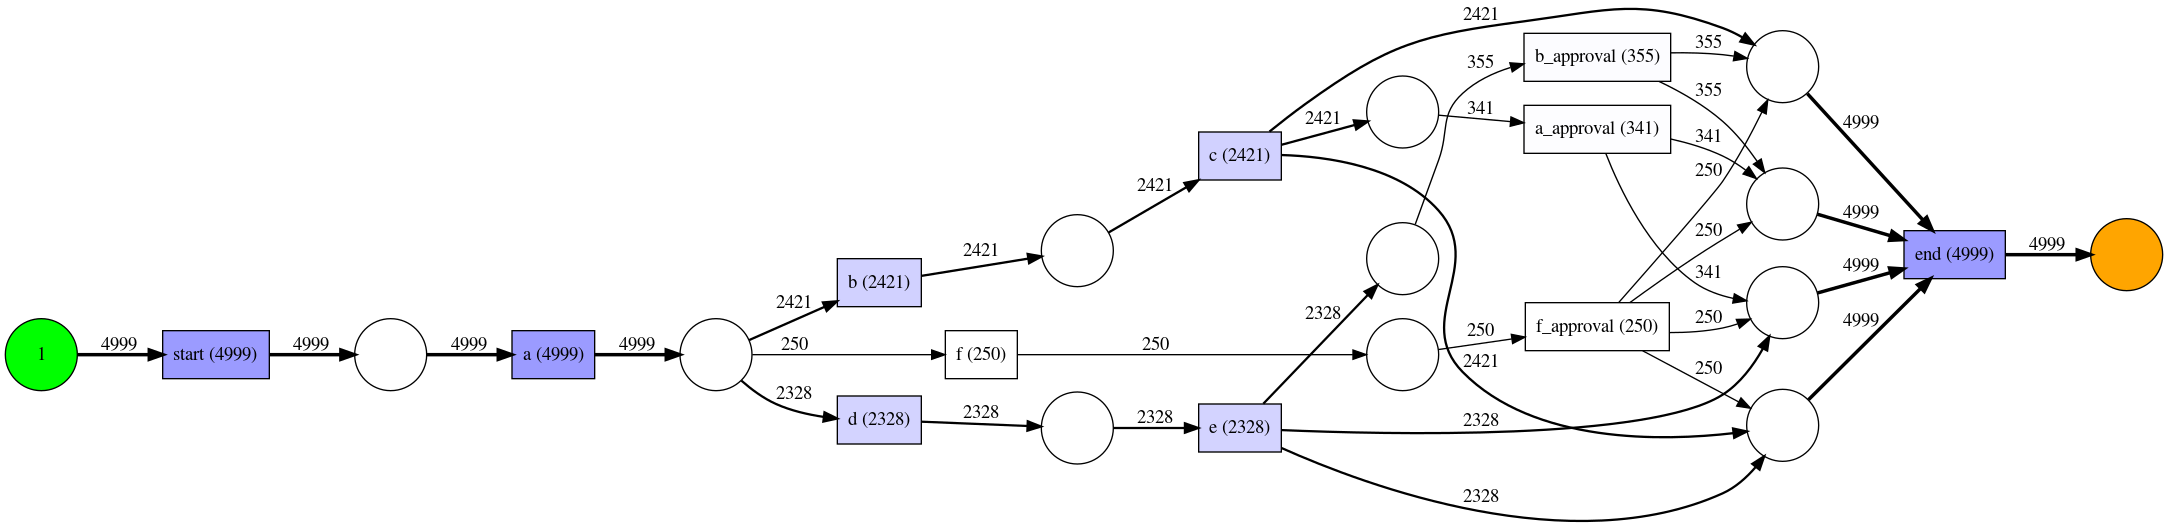

In [18]:
norm_gviz_am = pn_visualizer.apply(norm_net, norm_initial_marking, norm_final_marking,
                             parameters = viz_params,
                             variant=pn_visualizer.Variants.FREQUENCY,
                             log=sim_normevent_log)
pn_visualizer.view(norm_gviz_am)

Outlier flow

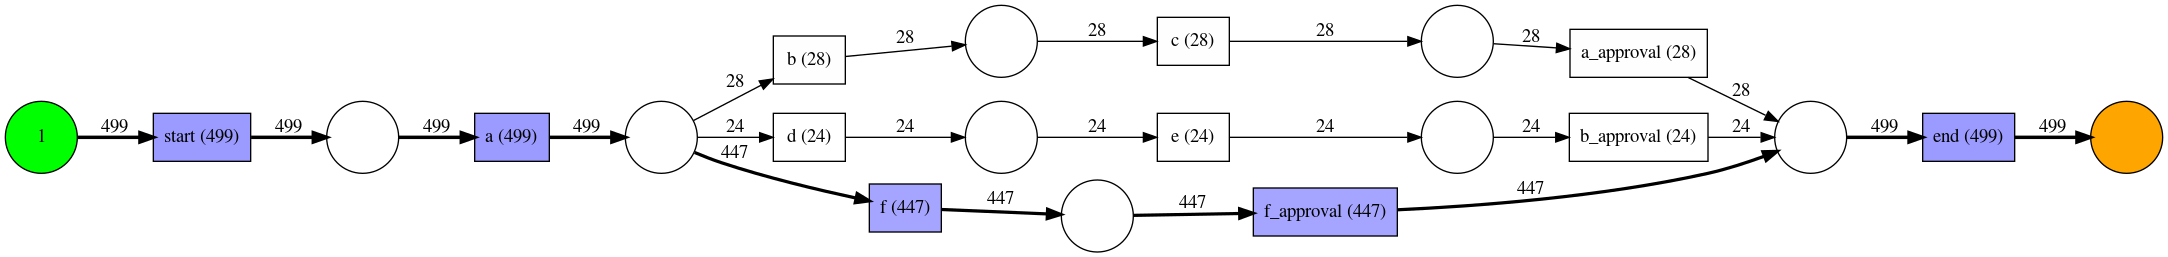

In [19]:
out_gviz_am = pn_visualizer.apply(out_net, out_initial_marking, out_final_marking,
                             parameters = viz_params,
                             variant=pn_visualizer.Variants.FREQUENCY,
                             log=sim_outevent_log)
pn_visualizer.view(out_gviz_am)

In [20]:
from pm4py.objects.log.util import get_log_representation

In [21]:
def neighbors_metrics(f_log):
    """
    Intakes the log for a temporal window. 
    Processes case count metrics for in scope event neighbors. 
    Returns pandas dataframe. 
    """
    try:
        tmp_data, tmp_feature_names = get_log_representation.get_representation(f_log, str_ev_attr=["case:concept:name", "concept:name"],
                                                                    str_tr_attr=[], num_ev_attr=[], num_tr_attr=[],
                                                                    str_evsucc_attr=["case:concept:name", "concept:name"])
        tmp_df = pd.DataFrame(tmp_data, columns = tmp_feature_names)
        tmp_agg = pd.DataFrame( tmp_df.sum() )
        tmp_agg.columns = ['case_count']
        tmp_agg = tmp_agg.iloc[tmp_agg.index.str.contains('success')]
        tmp_agg = tmp_agg.iloc[~tmp_agg.index.str.contains('case:concept')]
        tmp_agg.index = tmp_agg.index.str.replace('succession:concept:name@','')
        tmp_agg.index = tmp_agg.index.str.replace('#','_to_')
        tot_case_cnt = tmp_agg['case_count'].max()
        tmp_agg['norm_val'] = tmp_agg.loc[:,'case_count'].apply(lambda x : x / tot_case_cnt)
        tmp_agg = pd.DataFrame( tmp_agg.loc[~tmp_agg.index.isin(['start_to_a']), 'norm_val'] ) 
        base_neighbors_df = pd.DataFrame( [0,0,0,0,0,0,0,0,0,0,0,0,0] )
        base_neighbors_df.index = ['a_to_b',
         'a_to_d',
         'a_to_f',
         'a_approval_to_end',
         'b_to_c',
         'b_approval_to_end',
         'c_to_a_approval',
         'c_to_end',
         'd_to_e',
         'e_to_b_approval',
         'e_to_end',
         'f_to_f_approval',
         'f_approval_to_end']

        norm_merge = base_neighbors_df.merge(tmp_agg, how='left', left_index=True,right_index=True)
        norm_merge['norm_val'] = norm_merge['norm_val'].fillna(0)
        fnl_row = norm_merge['norm_val'].T.to_list()
        fnl = pd.DataFrame( [fnl_row] )
        fnl.columns = ['a_to_b',
         'a_to_d',
         'a_to_f',
         'a_approval_to_end',
         'b_to_c',
         'b_approval_to_end',
         'c_to_a_approval',
         'c_to_end',
         'd_to_e',
         'e_to_b_approval',
         'e_to_end',
         'f_to_f_approval',
         'f_approval_to_end']
        return fnl
    except:
        print('Error in processing metrics')

In [22]:
test_func = neighbors_metrics(sim_event_log)

In [23]:
test_func

,a_to_b,a_to_d,a_to_f,a_approval_to_end,b_to_c,b_approval_to_end,c_to_a_approval,c_to_end,d_to_e,e_to_b_approval,e_to_end,f_to_f_approval,f_approval_to_end
0,0.4639,0.4446,0.0915,0.0675,0.4639,0.0668,0.0675,0.3964,0.4446,0.0668,0.3778,0.0915,0.0915


In [24]:
batch_event_range = range(0,10000,100)
results_df = pd.DataFrame(columns = ['a_to_b',
         'a_to_d',
         'a_to_f',
         'a_approval_to_end',
         'b_to_c',
         'b_approval_to_end',
         'c_to_a_approval',
         'c_to_end',
         'd_to_e',
         'e_to_b_approval',
         'e_to_end',
         'f_to_f_approval',
         'f_approval_to_end'])
for batch in batch_event_range: 
    batch_sim_df = sim_event_df[(sim_event_df['case:concept:name'] >= batch) & (sim_event_df['case:concept:name'] < batch + 100)]
    batch_sim_log = log_converter.apply(batch_sim_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)
    batch_metrics = neighbors_metrics(batch_sim_log)
    batch_metrics.index = [batch]
    results_df = results_df.append(batch_metrics, ignore_index=False)

In [25]:
results_df.head()

,a_to_b,a_to_d,a_to_f,a_approval_to_end,b_to_c,b_approval_to_end,c_to_a_approval,c_to_end,d_to_e,e_to_b_approval,e_to_end,f_to_f_approval,f_approval_to_end
0,0.535354,0.434343,0.030303,0.10101,0.535354,0.080808,0.10101,0.434343,0.434343,0.080808,0.353535,0.030303,0.030303
100,0.550000,0.360000,0.090000,0.05000,0.550000,0.030000,0.05000,0.500000,0.360000,0.030000,0.330000,0.090000,0.090000
200,0.500000,0.470000,0.030000,0.05000,0.500000,0.090000,0.05000,0.450000,0.470000,0.090000,0.380000,0.030000,0.030000
300,0.520000,0.450000,0.030000,0.10000,0.520000,0.080000,0.10000,0.420000,0.450000,0.080000,0.370000,0.030000,0.030000
400,0.430000,0.520000,0.050000,0.06000,0.430000,0.050000,0.06000,0.370000,0.520000,0.050000,0.470000,0.050000,0.050000


In [26]:
results_df.iloc[ results_df.index == 5000]

,a_to_b,a_to_d,a_to_f,a_approval_to_end,b_to_c,b_approval_to_end,c_to_a_approval,c_to_end,d_to_e,e_to_b_approval,e_to_end,f_to_f_approval,f_approval_to_end
5000,0.06,0.05,0.89,0.06,0.06,0.05,0.06,0.0,0.05,0.05,0.0,0.89,0.89


In [27]:
from scipy.spatial import distance_matrix

In [28]:
neighbor_distance = pd.DataFrame(distance_matrix(results_df.values, results_df.values), index=results_df.index, columns=results_df.index)

In [29]:
neighbor_distance.head()

,0,100,200,300,400,500,600,700,800,900,...,9000,9100,9200,9300,9400,9500,9600,9700,9800,9900
0,0.000000,0.193406,0.106590,0.037976,0.246987,0.082577,0.133514,0.091777,0.137256,0.082092,...,0.214953,0.251130,0.042292,0.256989,0.152454,0.127631,0.138165,0.220993,0.150406,0.096105
100,0.193406,0.000000,0.228473,0.216333,0.349714,0.221133,0.291204,0.153297,0.284077,0.183848,...,0.189473,0.364143,0.168226,0.155242,0.257294,0.239792,0.135277,0.258844,0.142829,0.122474
200,0.106590,0.228473,0.000000,0.088318,0.184120,0.047958,0.117473,0.188414,0.141067,0.103923,...,0.175214,0.176635,0.102470,0.293769,0.131909,0.133041,0.180831,0.209284,0.139284,0.130384
300,0.037976,0.216333,0.088318,0.000000,0.211424,0.064031,0.100000,0.124499,0.109087,0.078740,...,0.205670,0.215870,0.051962,0.290000,0.120830,0.101489,0.159687,0.204450,0.146969,0.120830
400,0.246987,0.349714,0.184120,0.211424,0.000000,0.195448,0.149332,0.320936,0.166733,0.215174,...,0.212132,0.068557,0.231084,0.458912,0.113578,0.154272,0.310161,0.206155,0.217025,0.286880


In [30]:
avg_neighbor_distance = pd.DataFrame( neighbor_distance.mean() )

In [31]:
avg_neighbor_distance.columns = ['Avg_Distance_of_Case_Cnt']

In [32]:
avg_neighbor_distance['Batch_ID'] = avg_neighbor_distance.index

In [33]:
avg_neighbor_distance = avg_neighbor_distance.sort_values('Avg_Distance_of_Case_Cnt', ascending=False)

In [34]:
avg_neighbor_distance.head()

,Avg_Distance_of_Case_Cnt,Batch_ID
5100,1.771343,5100
5400,1.733692,5400
5000,1.696851,5000
5300,1.664999,5300
5200,1.664931,5200


In [35]:
std_dev = avg_neighbor_distance['Avg_Distance_of_Case_Cnt'].std()

In [36]:
avg = avg_neighbor_distance['Avg_Distance_of_Case_Cnt'].mean()

In [37]:
avg_neighbor_distance['Dist_Z_Score'] = avg_neighbor_distance['Avg_Distance_of_Case_Cnt'].apply(lambda x: abs( x - avg ) / std_dev )

In [38]:
avg_neighbor_distance.loc[ avg_neighbor_distance['Dist_Z_Score'] > 3, 'Outlier_Flag'] = 'Y'
avg_neighbor_distance.loc[ avg_neighbor_distance['Dist_Z_Score'] <= 3, 'Outlier_Flag'] = 'N'

In [49]:
pd.DataFrame(avg_neighbor_distance['Outlier_Flag'].value_counts(sort=True))

,Outlier_Flag
N,95
Y,5


In [50]:
avg_neighbor_distance[ avg_neighbor_distance['Outlier_Flag'] == 'Y']

,Avg_Distance_of_Case_Cnt,Batch_ID,Dist_Z_Score,Outlier_Flag
5100,1.771343,5100,4.510602,Y
5400,1.733692,5400,4.392667,Y
5000,1.696851,5000,4.277273,Y
5300,1.664999,5300,4.177505,Y
5200,1.664931,5200,4.177290,Y


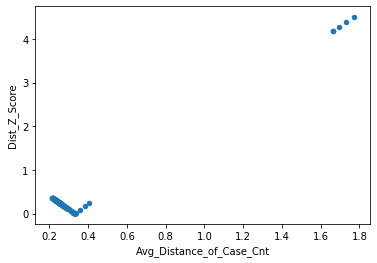

In [41]:
avg_neighbor_distance.plot.scatter(x='Avg_Distance_of_Case_Cnt',
                                  y='Dist_Z_Score')

In [53]:
outlier_batch_list = avg_neighbor_distance[ avg_neighbor_distance['Outlier_Flag'] == 'Y'].index.to_list()
norm_batch_list = avg_neighbor_distance[ avg_neighbor_distance['Outlier_Flag'] == 'N'].index.to_list()
outlier_to_show = outlier_batch_list[0]
norm_to_show = norm_batch_list[0]

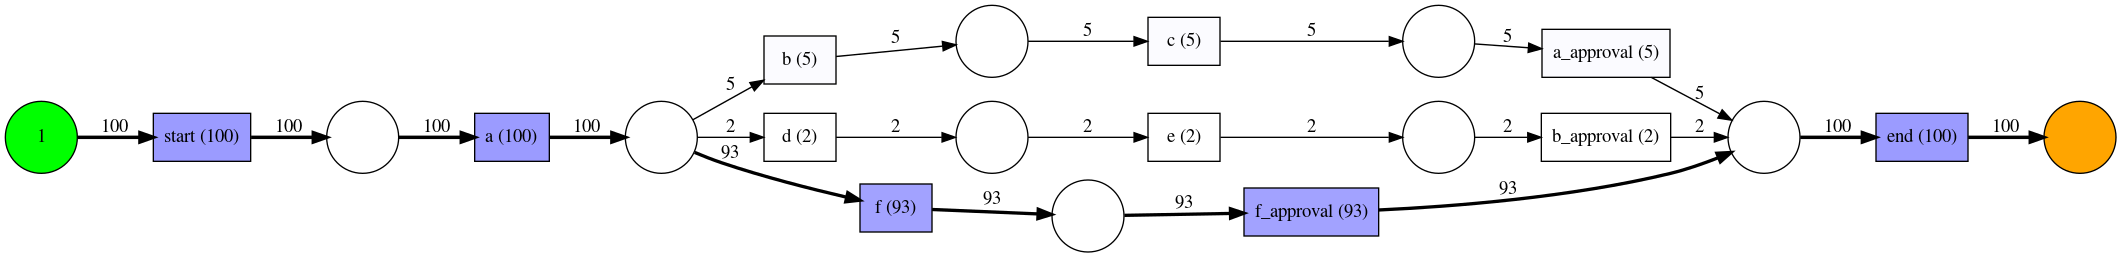

In [54]:
outlier_show_df = sim_event_df[(sim_event_df['case:concept:name'] >= outlier_to_show) & (sim_event_df['case:concept:name'] < outlier_to_show + 100)]
outlier_show_log = log_converter.apply(outlier_show_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)
outlier_net, outlier_initial_marking, outlier_final_marking = alpha_miner.apply(outlier_show_log)
outlier_gviz_am = pn_visualizer.apply(outlier_net, outlier_initial_marking, outlier_final_marking,
                             parameters = viz_params,
                             variant=pn_visualizer.Variants.FREQUENCY,
                             log=outlier_show_log)
pn_visualizer.view(outlier_gviz_am)

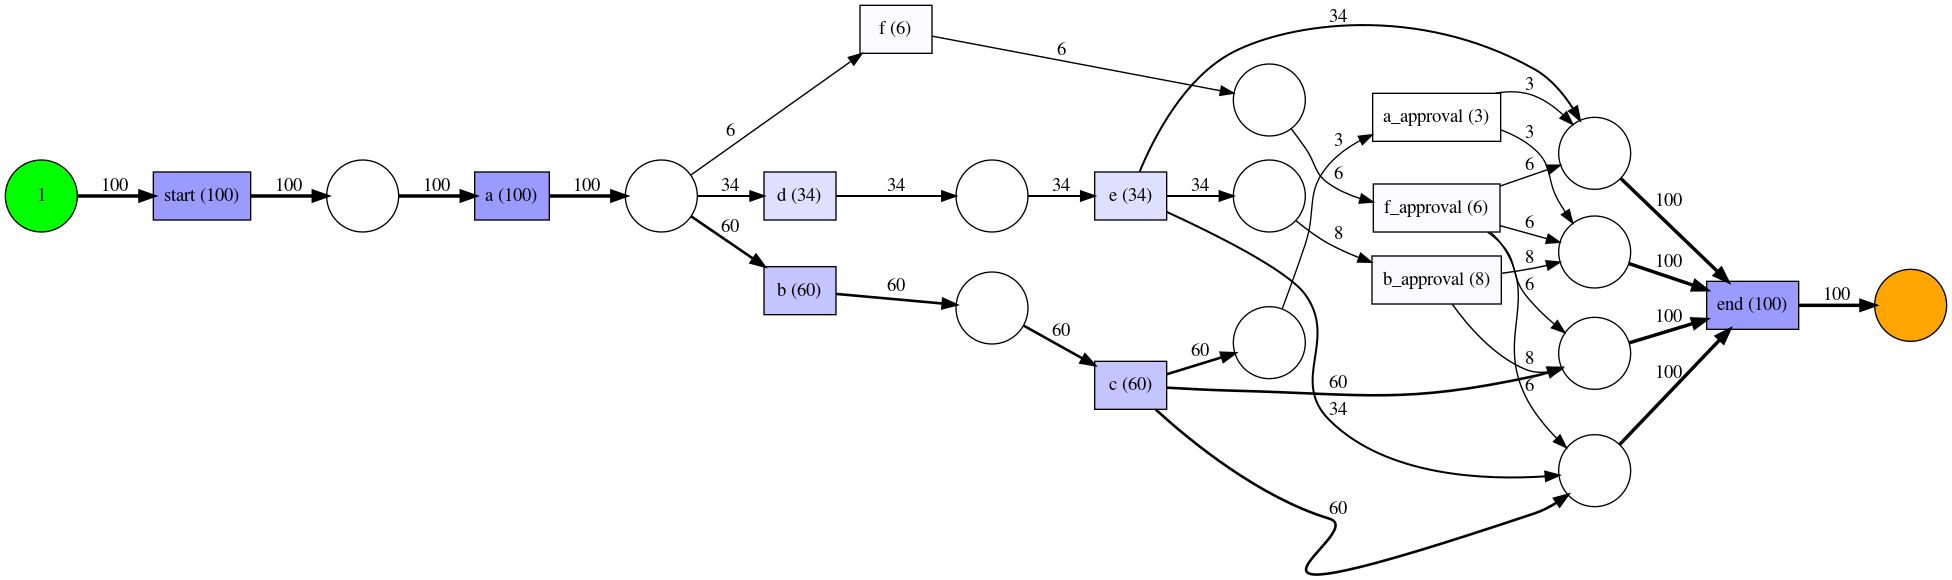

In [55]:
norm_show_df = sim_event_df[(sim_event_df['case:concept:name'] >= norm_to_show) & (sim_event_df['case:concept:name'] < norm_to_show + 100)]
norm_show_log = log_converter.apply(norm_show_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)
norm_net, norm_initial_marking, norm_final_marking = alpha_miner.apply(norm_show_log)
norm_gviz_am = pn_visualizer.apply(norm_net, norm_initial_marking, norm_final_marking,
                             parameters = viz_params,
                             variant=pn_visualizer.Variants.FREQUENCY,
                             log=norm_show_log)
pn_visualizer.view(norm_gviz_am)

In [ ]:
from pm4py.objects.log.util import get_log_representation

In [ ]:
data, feature_names = get_log_representation.get_representation(sim_event_log, str_ev_attr=["case:concept:name", "concept:name"],
                                                                str_tr_attr=[], num_ev_attr=[], num_tr_attr=[],
                                                                str_evsucc_attr=["case:concept:name", "concept:name"])

In [ ]:
test_df2 = pd.DataFrame(data, columns = feature_names)

In [ ]:
test_agg = pd.DataFrame( test_df2.sum() )

In [ ]:
test_agg.columns = ['case_count']

In [ ]:
test_agg = test_agg.iloc[test_agg.index.str.contains('success')]

In [ ]:
test_agg  = test_agg.iloc[~test_agg.index.str.contains('case:concept')]

In [ ]:
test_agg.index = test_agg.index.str.replace('succession:concept:name@','')

In [ ]:
test_agg.index = test_agg.index.str.replace('#','_to_')

In [ ]:
tot_case_cnt = test_agg['case_count'].max()
test_agg['norm_val'] = test_agg.loc[:,'case_count'].apply(lambda x : x / tot_case_cnt)

In [ ]:
test_agg

In [ ]:
test_agg2 = pd.DataFrame( test_agg.loc[~test_agg.index.isin(['start_to_a']), 'norm_val'] ) 

In [ ]:
test_agg2

In [ ]:
test_agg2.index.to_list()

In [ ]:
base_neighbors_df = pd.DataFrame( [0,0,0,0,0,0,0,0,0,0,0,0,0] )

In [ ]:
base_neighbors_df.index = ['a_to_b',
 'a_to_d',
 'a_to_f',
 'a_approval_to_end',
 'b_to_c',
 'b_approval_to_end',
 'c_to_a_approval',
 'c_to_end',
 'd_to_e',
 'e_to_b_approval',
 'e_to_end',
 'f_to_f_approval',
 'f_approval_to_end']

In [ ]:
norm_merge = base_neighbors_df.merge(test_agg2, how='left', left_index=True,right_index=True)

In [ ]:
norm_merge['norm_val'] = norm_merge['norm_val'].fillna(0)

In [ ]:
fnl_row = norm_merge['norm_val'].T.to_list()

In [ ]:
fnl_row

In [ ]:
test_format = []

In [ ]:
test_format.append([3,fnl_row])

In [ ]:
test_format2 = pd.DataFrame(test_format)

In [ ]:
test_format2

In [ ]:
test_agg3 = test_agg2.T

In [ ]:
test_agg3

In [ ]:
base_event_df = pd.DataFrame([0,0,0,0,0,0,0,0])

In [ ]:
base_event_df.columns = ['a_approval','b','b_approval','c','d','e','f','f_approval']

In [ ]:
base_event_df

In [ ]:
base_event_df.shape

In [ ]:
data, feature_names = get_log_representation.get_representation(sim_event_log, str_ev_attr=["case:concept:name", "concept:name"],
                                                                str_tr_attr=[], num_ev_attr=[], num_tr_attr=[],
                                                                str_evsucc_attr=["case:concept:name", "concept:name"])

In [ ]:
test_df2 = pd.DataFrame(data, columns = feature_names)

In [ ]:
test_df2.head()

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components = 5)

In [ ]:
test_df3 = pd.DataFrame(pca.fit_transform(test_df2))

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
model = IsolationForest()

In [ ]:
model.fit(test_df2)

In [ ]:
test_df2['scores'] = model.decision_function(test_df2)

In [ ]:
test_df3['@@index'] = test_df3.index
test_df3 = test_df3[['scores','@@index']]
test_df3 = test_df3.sort_values('scores')

In [ ]:
test_df2 = test_df2.sort_values('scores')

In [ ]:
test_df2.head(10)

In [ ]:
simulation_df[ simulation_df['flow_id'] == 5671]

In [ ]:
simulation_df.head(100)